##  Examples from  Paper

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from torch.distributions.normal import Normal
import torch.optim as optim
import torch.nn as nn
from nde.flows import realnvp
import tqdm
import matplotlib.pyplot as plt
from nde.flows import autoregressive as ar
import utils

torch.set_default_tensor_type(torch.FloatTensor)


def survey_sample(n, centre, rho = 1):
    # x = np.random.randn(n) * rho  + centre
    x = np.random.uniform(size=n, low =c1 - 3, high=c2 + 3)
    y = np.random.uniform(size=n, low =0, high=1)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

def calLoss(inputs, log_prob):
    return - (f(inputs)  / log_prob.exp() * log_prob).mean()

def filterInputs(inputs):
    return inputs[((inputs[:,0]>xlimits[0]) * (inputs[:,0]<xlimits[1]))
                  * ((inputs[:,1]>ylimits[0]) * (inputs[:,1]<ylimits[1]))]

def filterInputs_logj(inputs, logj):
    mask = ((inputs[:,0]>xlimits[0]) * (inputs[:,0]<xlimits[1])) \
           * ((inputs[:,1]>ylimits[0]) * (inputs[:,1]<ylimits[1]))
    return inputs[mask], logj[mask]

def plotHistory(history, level=10):
    history = np.array(history)
    idx =  np.where(history > level)[0][-1]
    history =  history[idx+1:]
    plt.plot(history)

# PDF

In [4]:
flow = realnvp.SimpleRealNVP(
    features=2,
    hidden_features=20,
    num_layers=15,
    num_blocks_per_layer=2,
)

# flow = ar.MaskedAutoregressiveFlow(
#             features=2,
#             hidden_features=30,
#             num_layers=20,
#             num_blocks_per_layer=2,
#         )


c1 = 1
c2 = 15
centre = (c1 + c2 )/2
xlimits = [-50, 200]
ylimits = [0, 1]
myNorm1 = Normal(torch.tensor([c1]), torch.tensor([0.5]))
myNorm2 = Normal(torch.tensor([c2]), torch.tensor([1.0]))
def f(x):
    return (x[:,1]>0) * (x[:,1]<1) * (myNorm1.log_prob(x[:,0]).exp() * 0.7 + myNorm2.log_prob(x[:,0]).exp() * 0.3)


optimizer_servy = optim.Adam(flow.parameters(), lr=1e-3)
history = []
for epoch in tqdm.notebook.tqdm(range(200), desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(500, 3)
        inputs = filterInputs(inputs)
    log_prob = flow.log_prob(inputs)
    optimizer_servy.zero_grad()
    loss = calLoss(inputs,  log_prob)
    loss.backward()
    optimizer_servy.step()
    history.append(loss.item())

print("===>", inputs[:,0].mean(), loss.item())
optimizer_refine = optim.Adam(flow.parameters(), lr=2e-4)
for epoch in tqdm.notebook.tqdm(range(1000), desc='Refine', leave=False):
    with torch.no_grad():
        inputs = flow.sample(2000).detach()
        inputs = filterInputs(inputs)
        if(epoch % 50 == 49):
            print(inputs[:,0].mean(), loss.item())
    log_prob = flow.log_prob(inputs)
    optimizer_refine.zero_grad()
    loss =  calLoss(inputs,  log_prob)
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotHistory(history, 15)

import matplotlib.pyplot as plt

with torch.no_grad():
    samples = flow.sample(5000)
    samples = filterInputs(samples)
    s0, s1 = samples[:,0], samples[:,1]

    print(s0.mean())
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0).detach().numpy(), bins=50,  range=(c1-8,  c2+8), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()


Survey:   0%|          | 0/200 [00:00<?, ?it/s]

InputOutsideDomain: 

Survey:   0%|          | 0/200 [00:00<?, ?it/s]

===> tensor(0.0364) 52.88867950439453


Refine:   0%|          | 0/1500 [00:00<?, ?it/s]

tensor(-0.3460) 3.565507650375366
tensor(-0.2706) 3.274974822998047
tensor(0.0426) 3.1483919620513916
tensor(0.0743) 3.0959877967834473
tensor(-0.0824) 2.922600507736206
tensor(-0.1137) 2.765427350997925
tensor(0.0689) 2.826314926147461
tensor(-0.0883) 2.80413818359375
tensor(0.1129) 2.7451741695404053
tensor(0.0167) 2.7508444786071777
tensor(-0.0787) 2.6661503314971924
tensor(0.0632) 2.8134307861328125
tensor(-0.2440) 2.672041416168213
tensor(-0.0204) 2.7279019355773926
tensor(0.0362) 2.821443557739258
==integral=> tensor(1.3167)


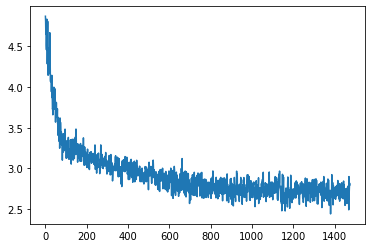

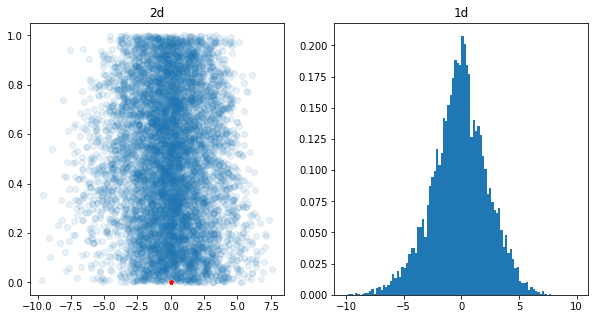

In [26]:
flow = realnvp.SimpleRealNVP(
    features=2,
    hidden_features=20,
    num_layers=8,
    num_blocks_per_layer=2,
)

# flow = ar.MaskedAutoregressiveFlow(
#             features=2,
#             hidden_features=30,
#             num_layers=20,
#             num_blocks_per_layer=2,
#         )

centre = 0.0
level = -0
xlimits = [-20, 20]
ylimits = [0, 1]

myNorm = Normal(torch.tensor([centre]), torch.tensor([1.0]))
def logf(x):
    return myNorm.log_prob(x[:,0]) + torch.log(x[:,0]>level) \
             + torch.log(x[:,1]>0) + torch.log(x[:,1]<1)

def survey_sample(n, centre, rho = 1):
    x = np.random.randn(n) * rho  + centre
    y = np.random.uniform(size=n, low =0, high=1)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

optimizer_servy = optim.Adam(flow.parameters(), lr=1e-2)
history = []
for epoch in tqdm.notebook.tqdm(range(200), desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(1000, 0)
        inputs  = filterInputs(inputs)
        # print(inputs.shape)
    log_prob = flow.log_prob(inputs)
    optimizer_servy.zero_grad()
    loss = calLoss(inputs, log_prob)
    loss.backward()
    if loss == torch.nan:
        break
    optimizer_servy.step()
    history.append(loss.item())

print("===>", inputs[:,0].mean(), loss.item())
optimizer_refine = optim.Adam(flow.parameters(), lr=2e-4)
for epoch in tqdm.notebook.tqdm(range(500), desc='Refine', leave=False):
    with torch.no_grad():
        inputs = flow.sample(1000).detach()
        inputs  = filterInputs(inputs)

        if(epoch % 100 == 99):
            print(inputs[:,0].mean(), loss.item())
    log_prob = flow.log_prob(inputs)
    optimizer_refine.zero_grad()
    loss = calLoss(inputs, log_prob)
    if loss == torch.nan:
        break
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotHistory(history, 5)

import matplotlib.pyplot as plt

with torch.no_grad():
    x, loggx = flow.sample_and_log_prob(10000)
    x, loggx = filterInputs_logj(x, loggx)
    # print(x.shape)
    s0, s1 = x[:,0], x[:,1]

    intgral = torch.exp(logf(x) - loggx).mean()

    print("==integral=>", intgral)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0).detach().numpy(), bins=100,  range=(-10,  10), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()

==integral=> tensor(1.2547)


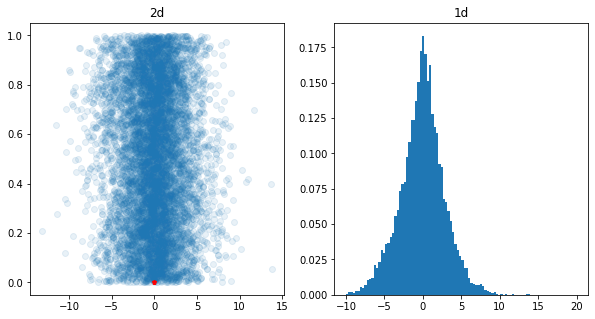

In [25]:
with torch.no_grad():
    x, loggx = flow.sample_and_log_prob(10000)
    x, loggx = filterInputs_logj(x, loggx)
    s0, s1 = x[:,0], x[:,1]

    intgral = torch.exp(logf(x) - loggx).mean()

    print("==integral=>", intgral)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0).detach().numpy(), bins=100,  range=(level-10,  level+20), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()

In [82]:
from scipy.stats import norm
import matplotlib.pyplot as plt
1-norm.cdf(1)

0.15865525393145707

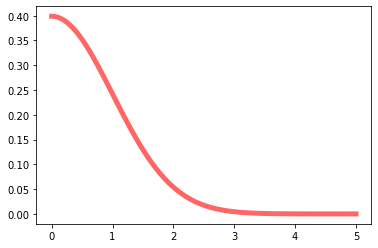

In [6]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 5, 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

$\{\boldsymbol{X}_{t},t\in\mathcal{T}\} $

$\boldsymbol{R}_{T}=\sum_{i=1}^{T}\boldsymbol{X}_{t}$

$\{\boldsymbol{R}_{T}\leq\gamma\}$

$P\{y_{t+k}=1|\boldsymbol{X}_{t}\}$

$\boldsymbol{X}$

$\boldsymbol{X}_{t-}=\{\boldsymbol{X}_{t},\boldsymbol{X}_{t-1},\cdots\}$

In [ ]:
with torch.no_grad():
    x, loggx = flow.sample_and_log_prob(10000)
    x, loggx = filterInputs_logj(x, loggx)
    s0, s1 = x[:,0], x[:,1]

    intgral = torch.exp(logf(x) - loggx).mean()

    print(intgral)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0).detach().numpy(), bins=100,  range=(level-10,  level+20), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()

In [ ]:
flow = realnvp.SimpleRealNVP(
    features=2,
    hidden_features=20,
    num_layers=10,
    num_blocks_per_layer=2,
)

# flow = ar.MaskedAutoregressiveFlow(
#             features=2,
#             hidden_features=30,
#             num_layers=20,
#             num_blocks_per_layer=2,
#         )

centre = 0
level = 10
centre_servey =  level + 0.2

xlimits = [0, 30]
ylimits = [0, 30]

def f(x):
    return torch.FloatTensor(np.exp(-x[:, 0] -x[:, 1])) * (x[:,0] + x[:,1] > level) * (x[:,0]>0)* (x[:,1]>0)

def logf(x):
      return -x[:, 0] -x[:, 1] + torch.log(x[:,0] + x[:,1] > level) \
             + torch.log(x[:,0]>0) + torch.log(x[:,1]>0)

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

def survey_sample(n, centre, rho = 1):
    x = np.random.uniform(size=n, low =0, high=level*1.5)
    y = np.random.uniform(size=n, low =0, high=level*1.5)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

optimizer_servy = optim.Adam(flow.parameters(), lr=1e-3)
history = []
for epoch in tqdm.notebook.tqdm(range(200), desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(1000, centre_servey)
        inputs =  filterInputs(inputs)
    log_prob = flow.log_prob(inputs)
    optimizer_servy.zero_grad()
    loss = calLoss(inputs, log_prob)
    # loss = - (f(inputs) * log_prob / log_prob.exp() ).mean() #  (log_prob/logf(inputs) ).mean()
    loss.backward()
    optimizer_servy.step()
    history.append(loss.item())

print("===>", inputs[:,0].mean(), loss.item())
optimizer_refine = optim.Adam(flow.parameters(), lr=1e-3)
for epoch in tqdm.notebook.tqdm(range(1000), desc='Refine', leave=False):
    with torch.no_grad():
        inputs = flow.sample(800).detach()
        inputs =  filterInputs(inputs)
        if(epoch % 50 == 49):
            print(inputs[:,0].mean(), loss.item())
    log_prob = flow.log_prob(inputs)
    optimizer_refine.zero_grad()
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotHistory(history, 0.01)

import matplotlib.pyplot as plt

with torch.no_grad():
    samples = flow.sample(3000)
    samples = filterInputs(samples)
    s0, s1 = samples[:,0], samples[:,1]
    print(s0.mean())
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0+s1).detach().numpy(), bins=100,  range=(level-10,  level+20), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()

    def myexp(x):
        return np.exp(-x) *  (x>10)
    x = np.linspace(0,20,100)
    plt.plot(x,  myexp(x))

In [ ]:
with torch.no_grad():
    samples = flow.sample(10000)
    samples = filterInputs(samples)
    s0, s1 = samples[:,0], samples[:,1]
    print(s0.mean())
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0+s1).detach().numpy(), bins=100,  range=(level-10,  level+20), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()

    def myexp(x):
        return np.exp(-x) *  (x>10)
    x = np.linspace(0,20,100)
    plt.plot(x,  myexp(x))

In [4]:
flow = realnvp.SimpleRealNVP(
    features=2,
    hidden_features=20,
    num_layers=10,
    num_blocks_per_layer=2,
)

# flow = ar.MaskedAutoregressiveFlow(
#             features=2,
#             hidden_features=30,
#             num_layers=20,
#             num_blocks_per_layer=2,
#         )

centre = 0
level = 10
centre_servey =  level + 0.2

xlimits = [0, 30]
ylimits = [0, 30]

def f(x):
    return torch.FloatTensor(np.exp(-x[:, 0] -x[:, 1])) * (x[:,0] + x[:,1] > level) * (x[:,0]>0)* (x[:,1]>0)

def logf(x):
      return -x[:, 0] -x[:, 1] + torch.log(x[:,0] + x[:,1] > level) \
             + torch.log(x[:,0]>0) + torch.log(x[:,1]>0)

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

def survey_sample(n, centre, rho = 1):
    x = np.random.uniform(size=n, low =0, high=level*1.5)
    y = np.random.uniform(size=n, low =0, high=level*1.5)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

optimizer_servy = optim.Adam(flow.parameters(), lr=1e-3)
history = []
for epoch in tqdm.notebook.tqdm(range(200), desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(1000, centre_servey)
        inputs =  filterInputs(inputs)
    log_prob = flow.log_prob(inputs)
    optimizer_servy.zero_grad()
    loss = calLoss(inputs, log_prob)
    # loss = - (f(inputs) * log_prob / log_prob.exp() ).mean() #  (log_prob/logf(inputs) ).mean()
    loss.backward()
    optimizer_servy.step()
    history.append(loss.item())

print("===>", inputs[:,0].mean(), loss.item())
optimizer_refine = optim.Adam(flow.parameters(), lr=1e-3)
for epoch in tqdm.notebook.tqdm(range(1000), desc='Refine', leave=False):
    with torch.no_grad():
        inputs = flow.sample(800).detach()
        inputs =  filterInputs(inputs)
        if(epoch % 50 == 49):
            print(inputs[:,0].mean(), loss.item())
    log_prob = flow.log_prob(inputs)
    optimizer_refine.zero_grad()
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotHistory(history, 0.01)

import matplotlib.pyplot as plt

with torch.no_grad():
    samples = flow.sample(3000)
    samples = filterInputs(samples)
    s0, s1 = samples[:,0], samples[:,1]
    print(s0.mean())
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0+s1).detach().numpy(), bins=100,  range=(level-10,  level+20), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()

    def myexp(x):
        return np.exp(-x) *  (x>10)
    x = np.linspace(0,20,100)
    plt.plot(x,  myexp(x))

Survey:   0%|          | 0/200 [00:00<?, ?it/s]

InputOutsideDomain: 

tensor(5.9640)


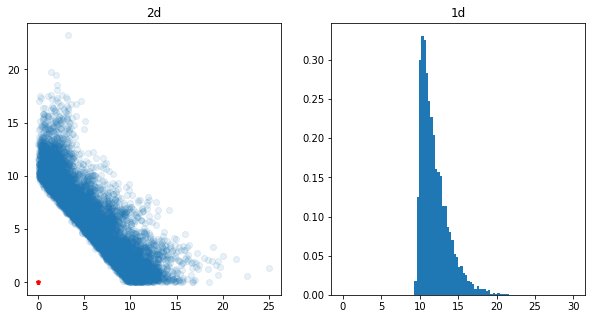

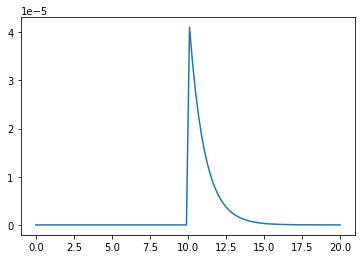

In [5]:
with torch.no_grad():
    samples = flow.sample(10000)
    samples = filterInputs(samples)
    s0, s1 = samples[:,0], samples[:,1]
    print(s0.mean())
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0+s1).detach().numpy(), bins=100,  range=(level-10,  level+20), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()

    def myexp(x):
        return np.exp(-x) *  (x>10)
    x = np.linspace(0,20,100)
    plt.plot(x,  myexp(x))